# Procesamiento y Clasificación de Datos
***
- Tarea 3 Análisis y Predicción
- Estudiante: Orestes Boffill Beltrán
-  Matrícula: 2085377
- Maestría de Ciencia de Datos
***

In [1]:
import warnings as wn
wn.filterwarnings('ignore')

# Descripción de los datos:

**Attribute Information**:

- ID number
- Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

1. radius (mean of distances from center to points on the perimeter) 
2. texture (standard deviation of gray-scale values) 
3. perimeter 
4. area 
5. smoothness (local variation in radius lengths) 
6. compactness (perimeter^2 / area - 1.0) 
7. concavity (severity of concave portions of the contour) 
8. concave points (number of concave portions of the contour)
9. symmetry
10. fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

# Cargando los paquetes y los datos

In [2]:
import numpy as np 
import pandas as pd 

import seaborn as sns 

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm

from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.inspection import permutation_importance

from imblearn.over_sampling import ADASYN


from xgboost import XGBClassifier
from xgboost import plot_importance

import time

## Configuración de parámetros de visualización y de "split"

In [3]:
plt.style.use('seaborn')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

cmap = cm.get_cmap('gnuplot')

seed = 730915
test_set_size = 0.20
val_set_size = 0.20

In [4]:
data = pd.read_csv('E:/MCD/Documentos/data.csv', encoding='ISO8859-1')

In [34]:
def plot_custom_confusion_matrix(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="YlGnBu")
    plt.savefig(filename)

<h2 align=center> Análisis Exploratorio </h2>

---

### Separando Target de las Features

In [5]:
data.head(n=10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [6]:
cols = data.columns       
print(cols)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [7]:
y = data['diagnosis']                           
drop_cols = ['Unnamed: 32','id','diagnosis']
X = data.drop(drop_cols, axis = 1)
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Plot Diagnosis

Number of Benign: 357
Number of Malignant : 212


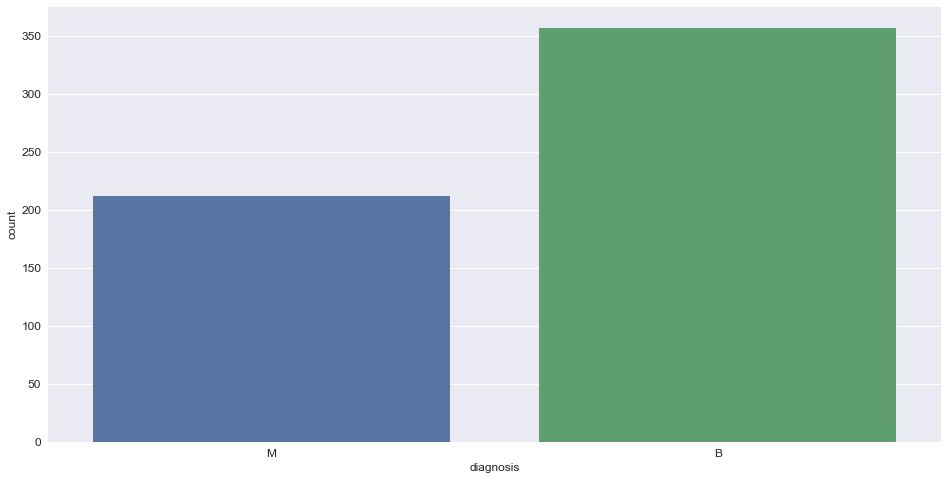

In [8]:
ax = sns.countplot(x=y, label="Count")

benign, malignant = y.value_counts()

print(f'Number of Benign: {benign}')
print(f'Number of Malignant : {malignant}')

In [9]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


<h2 align=center> Visualización de los datos </h2>

---

### Visualizando datos estandarizados con Seaborn

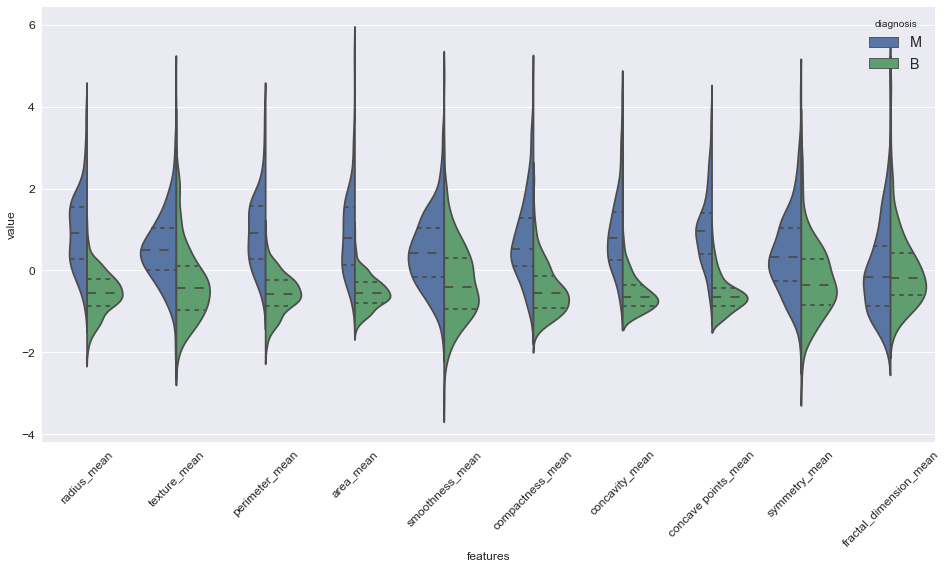

In [10]:
data_dia = y
data = X
data_n_2 = (data - data.mean()) / (data.std())              
data = pd.concat([y,data_n_2.iloc[:, 0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')


sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")

plt.xticks(rotation=45);

### Violin Plots y Box Plots

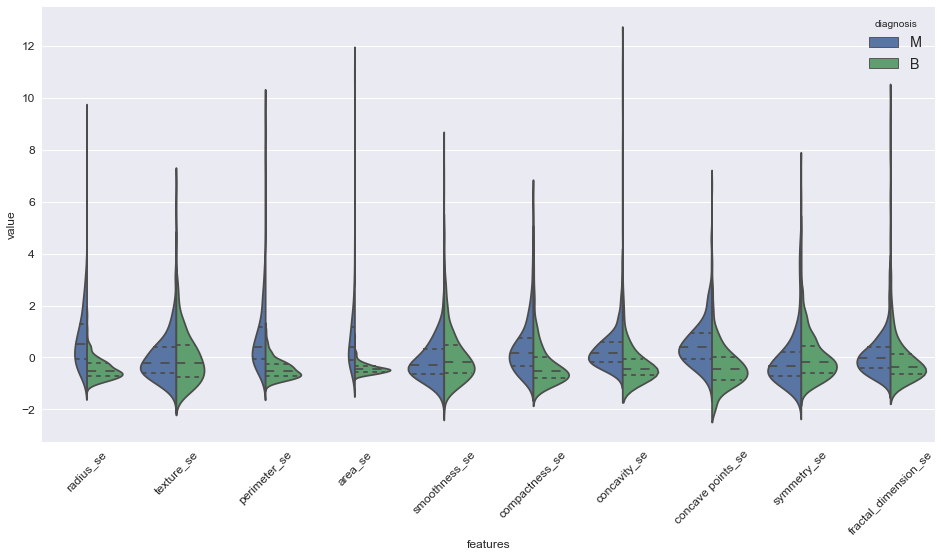

In [11]:
data = pd.concat([y,data_n_2.iloc[:, 10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=45);

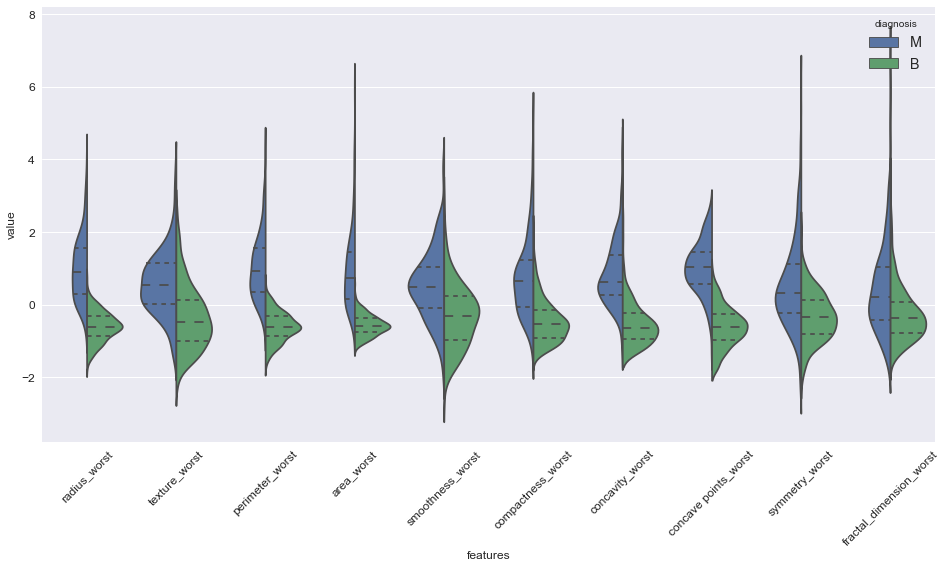

In [12]:
data = pd.concat([y,data_n_2.iloc[:, 20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=45);

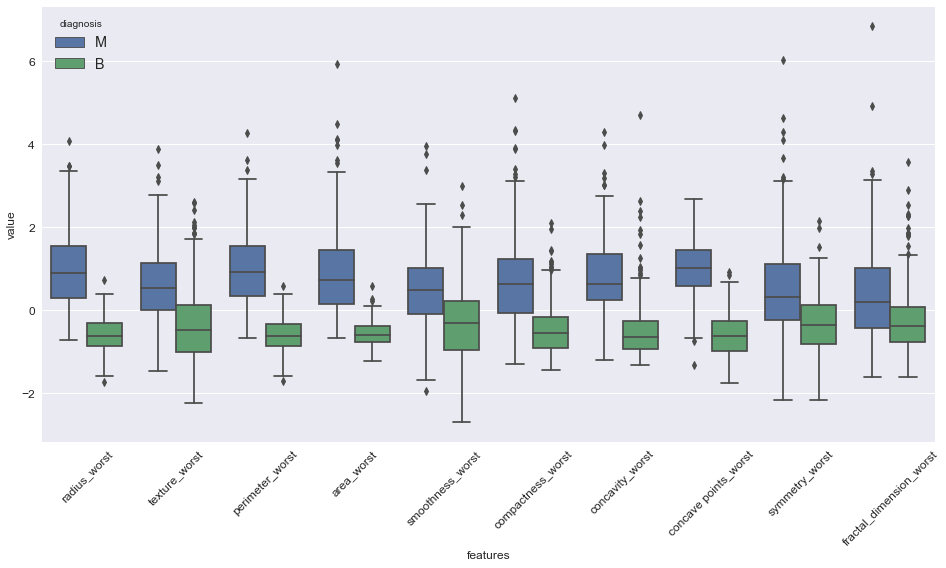

In [13]:
sns.boxplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=45);

### Joint Plots para comparar Feature

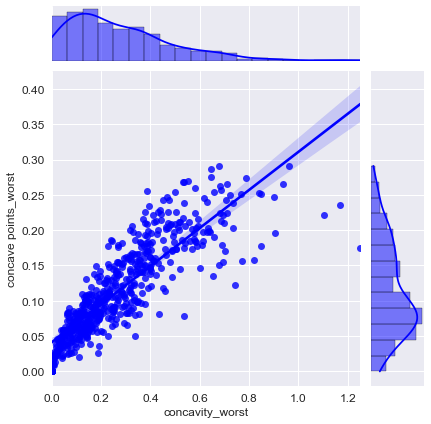

In [14]:
sns.jointplot(X.loc[:,'concavity_worst'],
              X.loc[:,'concave points_worst'],
              kind="reg",
              ax=ax,
              color="blue")

###  Observando la distribución de valores y sus varianzas con Swarm Plots

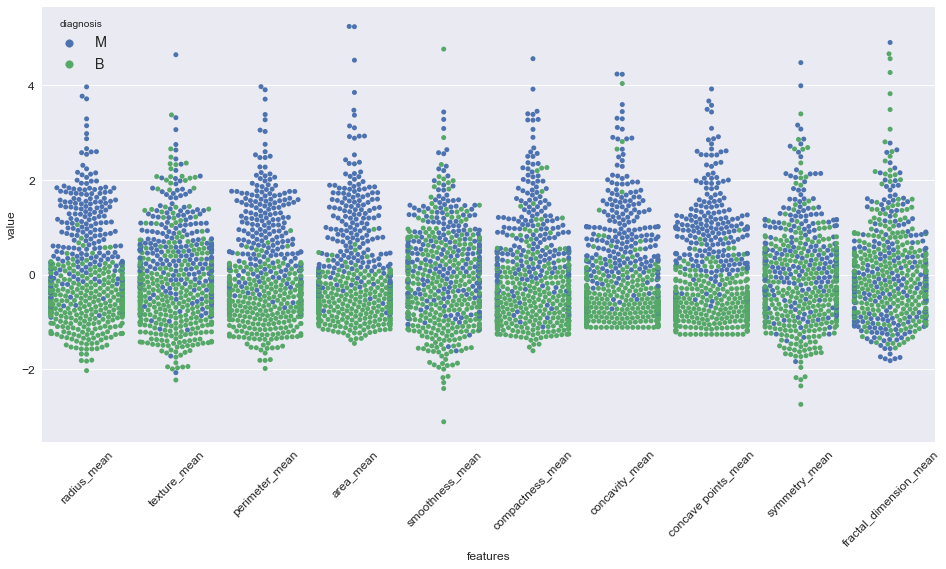

In [15]:
data_dia = y
data = X
data_n_2 = (data - data.mean()) / (data.std())  
data = pd.concat([y,data_n_2.iloc[:, 0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=45);

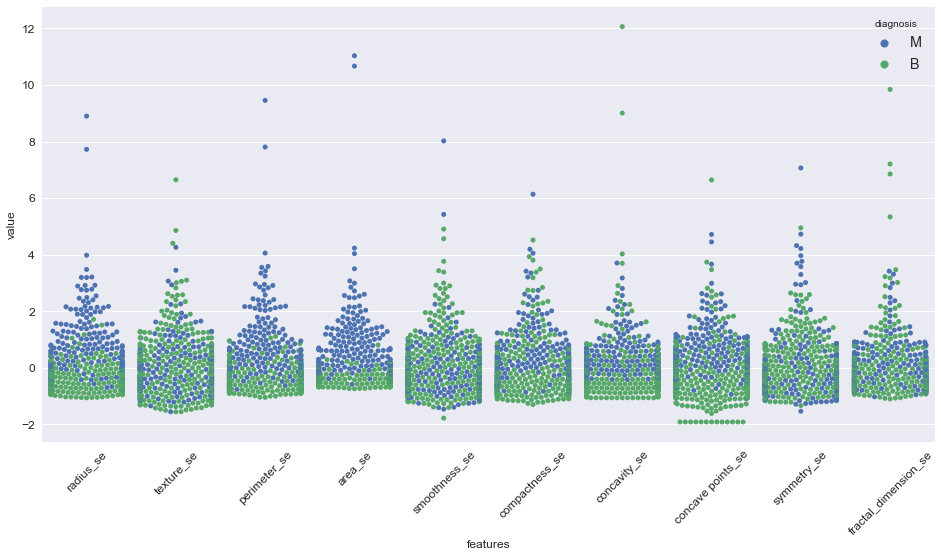

In [16]:
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=45);

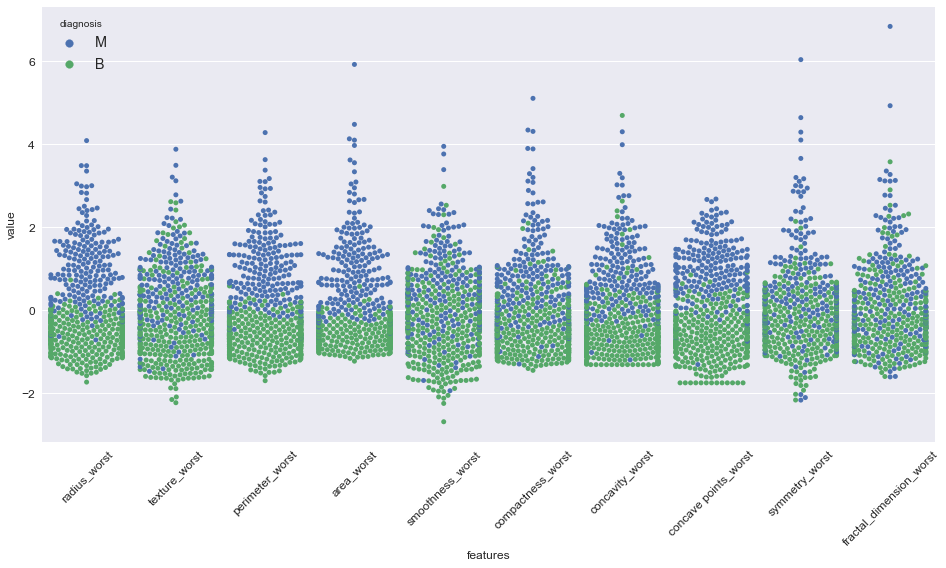

In [17]:
data = pd.concat([y,data_n_2.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=45);

### Observando todas las correlaciones

<AxesSubplot:>

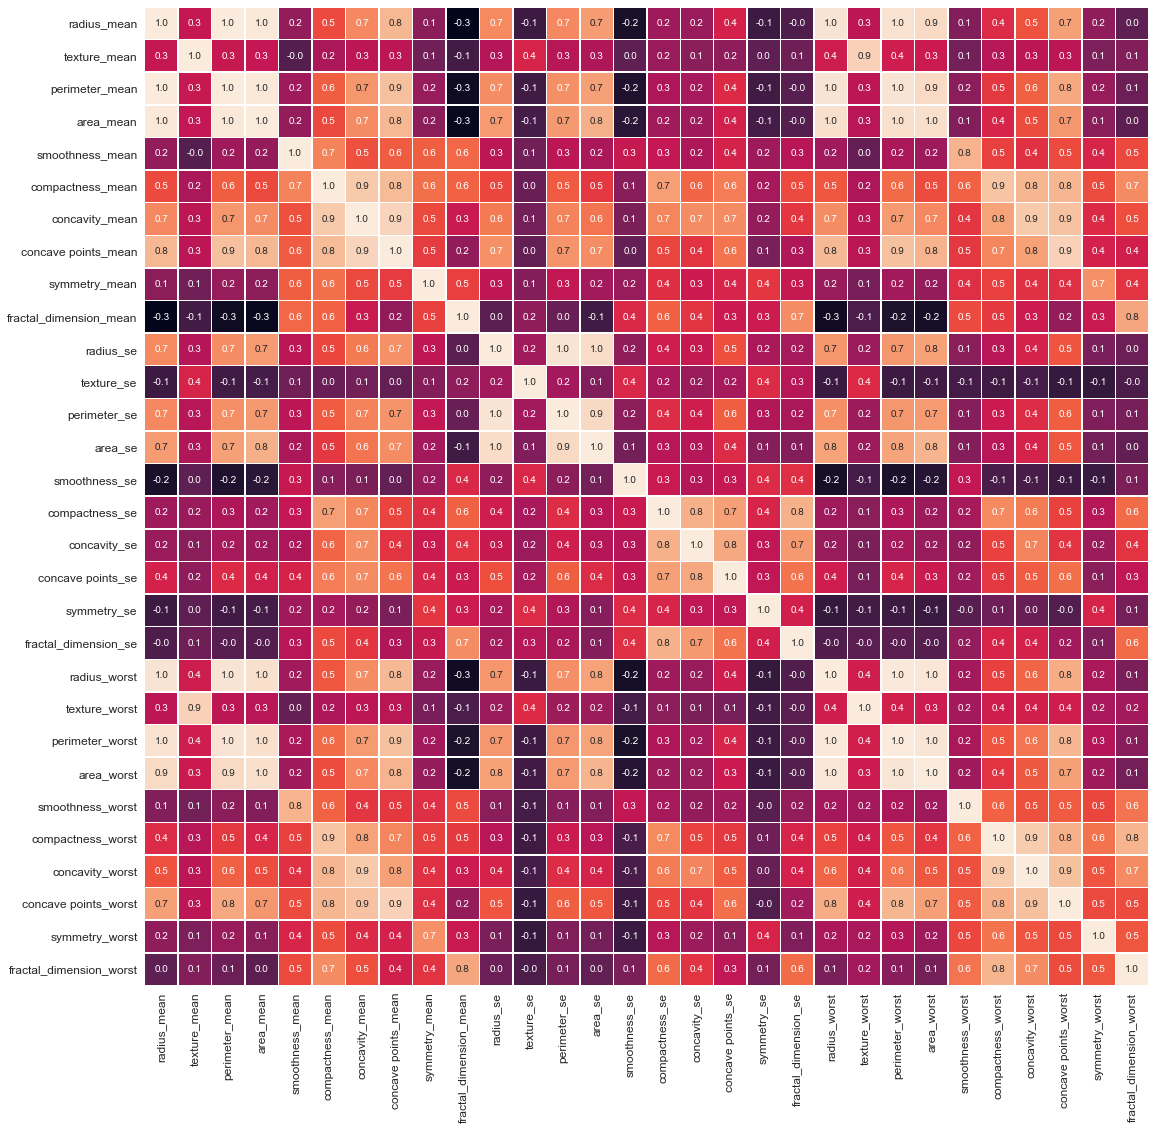

In [18]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cbar=False)

### Dropping columnas correlacionadas de Feature Matrix

In [21]:
drop_cols = ['perimeter_mean','radius_mean','compactness_mean',
              'concave points_mean','radius_se','perimeter_se',
              'radius_worst','perimeter_worst','compactness_worst',
              'concave points_worst','compactness_se','concave points_se',
              'texture_worst','area_worst']


In [22]:
X.drop(columns=drop_cols, inplace=True, errors='ignore')

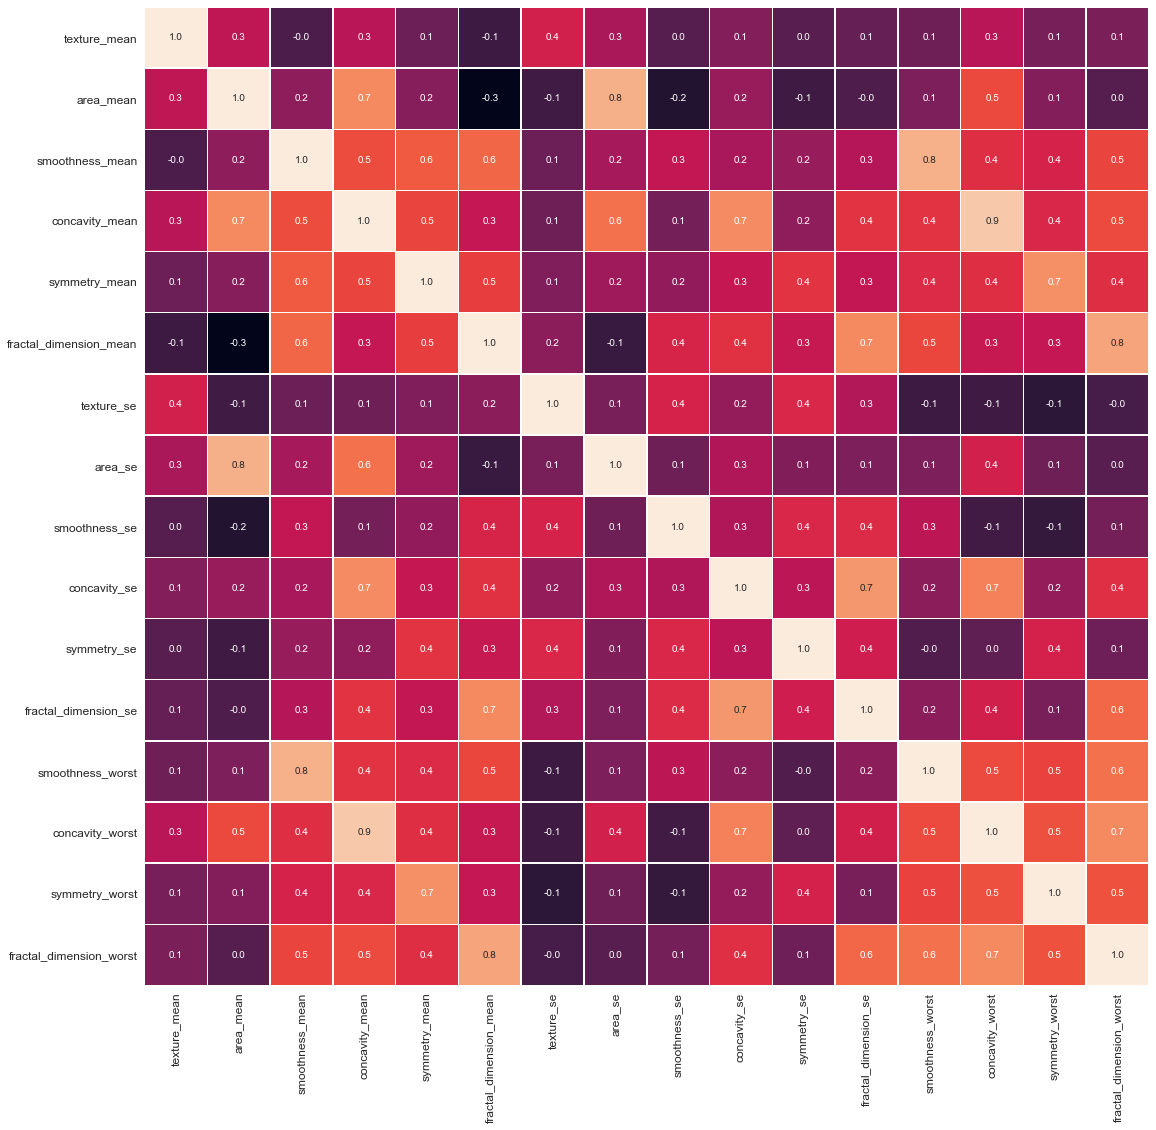

In [23]:
f, ax = plt.subplots(figsize=(18, 18))
_ = sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cbar=False)

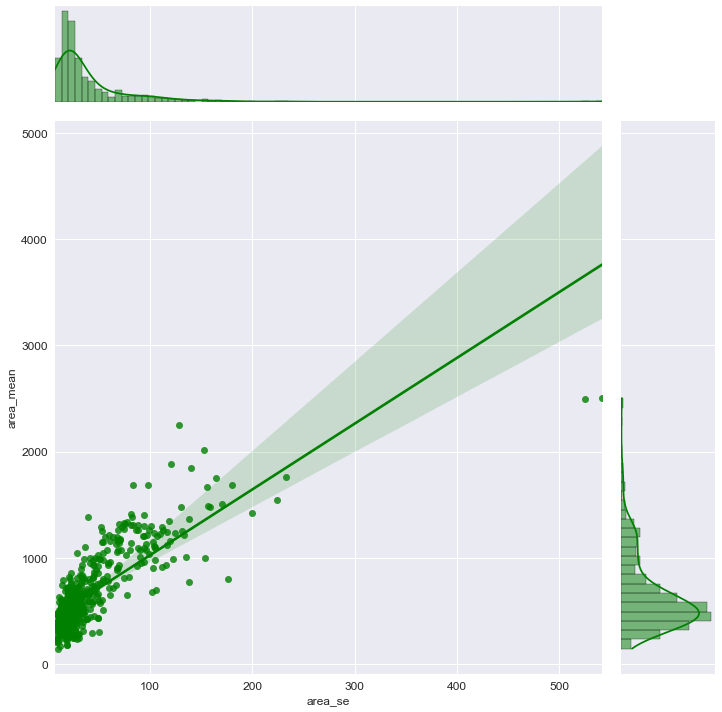

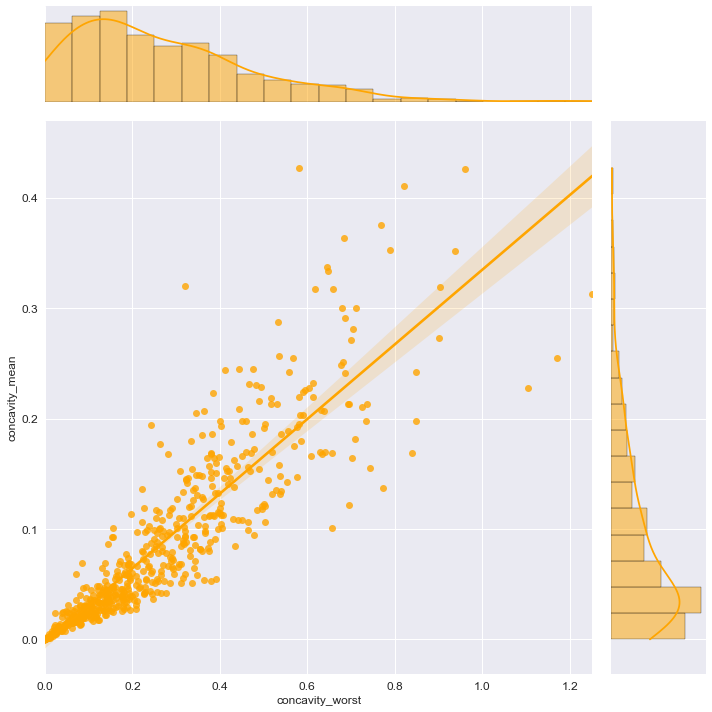

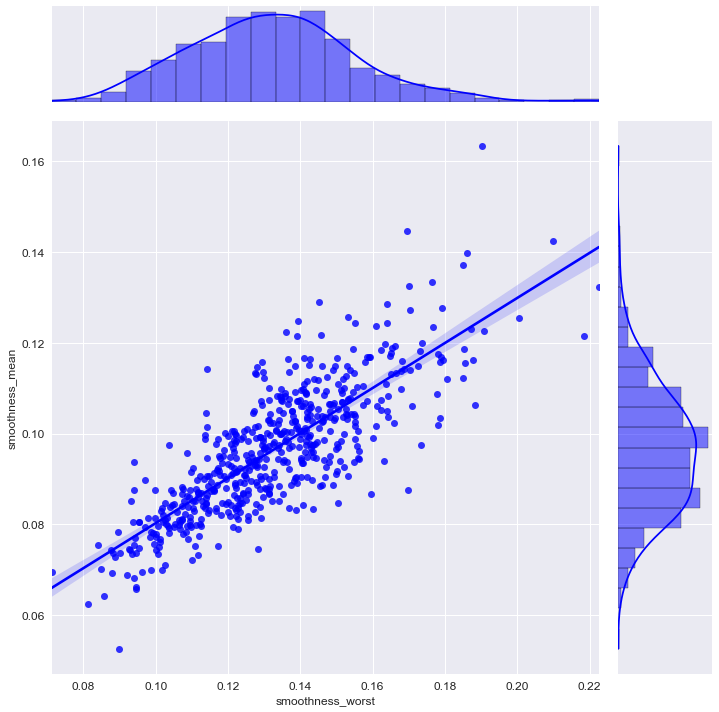

In [33]:
columns = [
    [
        'area_se', 
        'area_mean',
        'green'
    ],
    [
        'concavity_worst',
        'concavity_mean',
        'orange'
    ],
    [
        'smoothness_worst',
        'smoothness_mean',
        'blue'
    ]
]

for idx, column in enumerate(columns):
    sns.jointplot(
        X.loc[:,column[0]],
        X.loc[:, column[1]],
        kind="reg",
        ax=idx,
        color=column[2],
        height=10
    )

# Clasificación con XGBoost (minimal feature selection)

## Creando los datasets de entrenamiento, prueba y validación

In [41]:
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=val_set_size, 
    stratify=y, 
    random_state=seed
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, 
    y_train, 
    test_size=test_set_size, 
    stratify=y_train, 
    random_state=seed
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((364, 16), (364,), (91, 16), (91,), (114, 16), (114,))

## Verificando el balanceo de las clases dentro del dataset

In [53]:
for key, value in Counter(y).items():
    print(f'Clase {key} -- conteo {value} --- {round((value/y.shape[0]) * 100, 2)}%')

Clase M -- conteo 212 --- 37.26%
Clase B -- conteo 357 --- 62.74%


In [54]:
counter = Counter(y)
counter

scale_pos_weight_1 = counter['M'] / counter['B']
scale_pos_weight_2 = counter['B'] / counter['M']

scale_pos_weight_1, scale_pos_weight_2

(0.5938375350140056, 1.6839622641509433)

## Estrategia de balanceo usando ADASYNC

In [55]:
ada = ADASYN(random_state=seed)

X_train_res, y_train_res = ada.fit_resample(X_train, y_train)
print('Conjunto de entranamiento balanceado')
for key, values in Counter(y_train_res).items():
    print(f'Clase: {key} - conteo: {values} -> {(values / y_train_res.shape[0]):.2f}')
print()    
print('Conjunto de prueba balanceado')
X_test_res, y_test_res = ada.fit_resample(X_test, y_test)
for key, values in Counter(y_test_res).items():
    print(f'Clase: {key} - conteo: {values} -> {(values / y_test_res.shape[0]):.2f}')    
    

Conjunto de entranamiento balanceado
Clase: B - conteo: 228 -> 0.49
Clase: M - conteo: 233 -> 0.51

Conjunto de prueba balanceado
Clase: B - conteo: 57 -> 0.50
Clase: M - conteo: 58 -> 0.50


## Configurando los parámetros iniciales del XGBoost
***
Estos parámetros se obtuvieron corriendo varias veces el modelo sin hace uns búsqueda intensiva de parametros, se fueron probando 1 a 1, esta experimentación no se presenta en el jupyter notebook para no hacerlo muy extenso
***

In [56]:
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric=['aucpr', 'auc'],
    nthread=4,
    seed=seed
)

## Haciendo una revisión estratificada para ver si la selección de los datos afecta el resultado del modelo

In [57]:
r_stkfold_cv = RepeatedStratifiedKFold(
    n_splits=5, 
    n_repeats=3, 
    random_state=seed
)

## Parámetros para el hypertuning del modelo

In [58]:
parameters = {
    'nthread':[-1], 
    'objective':['binary:logistic'],
    'learning_rate': [0.5, 0.1, 0.01, 0.001], 
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [8, 11],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'n_estimators': [100, 500, 1000],
    'scale_pos_weight' : [
        1,
        np.sqrt(scale_pos_weight_1), 
        np.sqrt(scale_pos_weight_2),
        scale_pos_weight_1, 
        scale_pos_weight_2
    ]
}

grid_HS = GridSearchCV(
    estimator=xgb_clf, 
    param_grid=parameters, 
    n_jobs=-1, 
    verbose=2,
    refit=True,
    cv=r_stkfold_cv, 
    scoring='recall'
)

## Buscando la mejor combinación de híper-parametros para el modelo

In [59]:
grid_result_HS = grid_HS.fit(    
    X_train_res, 
    y_train_res
)

Fitting 15 folds for each of 480 candidates, totalling 7200 fits


In [62]:
model_HS = grid_result_HS.best_estimator_

## Matriz de confusión sobre el conjunto de entrenamiento

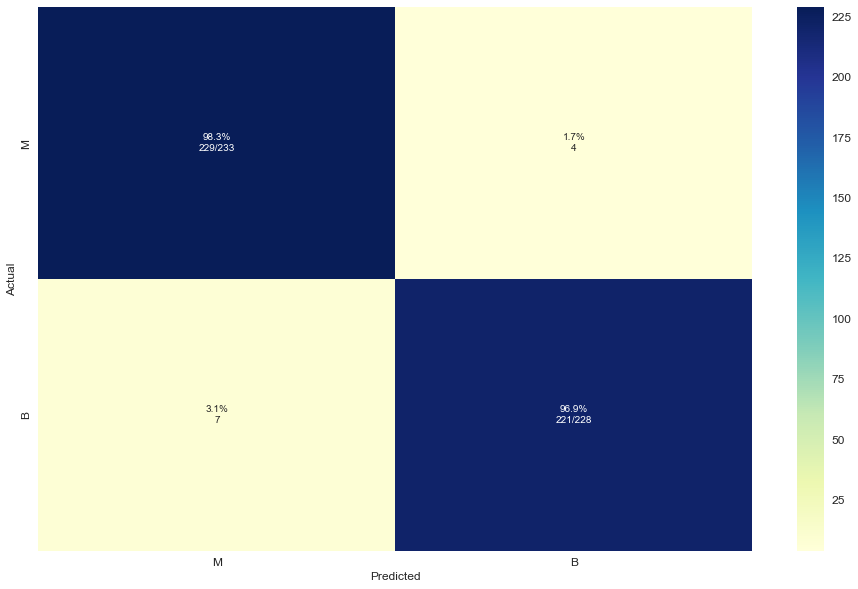

In [66]:
y_hat = model_HS.predict(X_train_res)
plot_custom_confusion_matrix(
    y_train_res, 
    y_hat, 
    'Conjunto de entrenamiento - Clasificador XGBoost', 
    ['M', 'B'], 
    ymap=None, 
    figsize=(16,10)
)

## Matriz de confusión sobre el conjunto de prueba

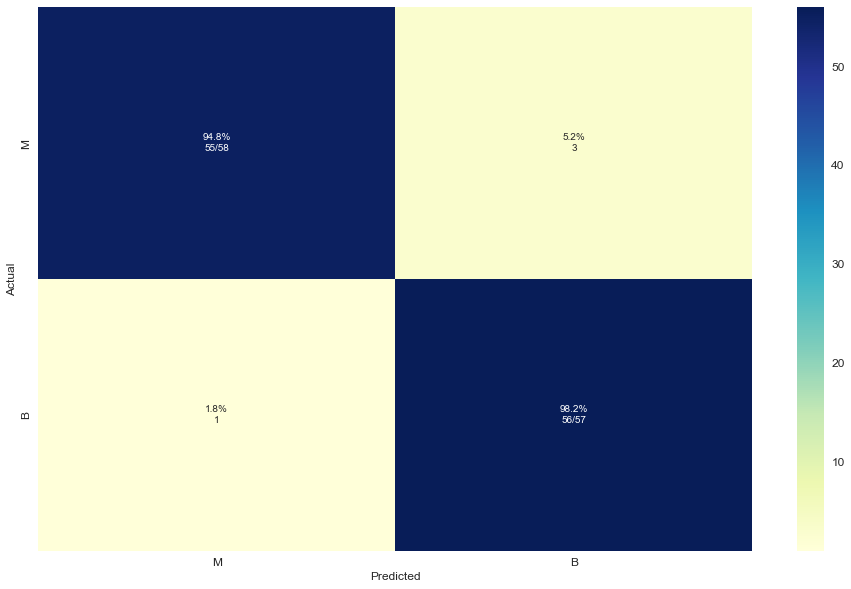

In [67]:
y_hat = model_HS.predict(X_test_res)
plot_custom_confusion_matrix(
    y_test_res, 
    y_hat, 
    'Conjunto de prueba - Classificador XGBoost', 
    ['M', 'B'], 
    ymap=None, 
    figsize=(16,10)
)

## Matriz de confusión sobre el conjunto de validación
***
Este conjunto de datos no ha sido visto por el modelo, en ninguna de sus dos versiones:
- Modelo sin hypertuning
- Modelo con hypertuning
***

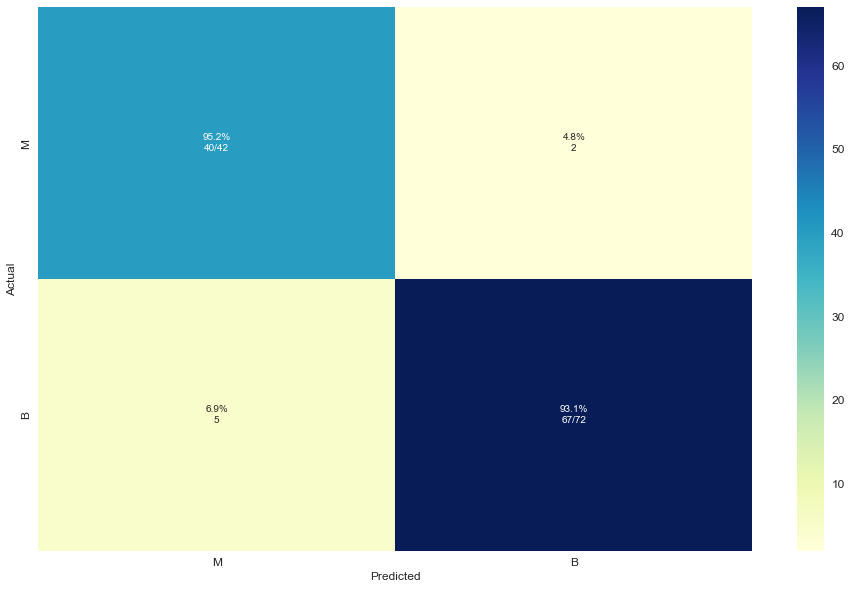

In [68]:
y_hat = model_HS.predict(X_val)
plot_custom_confusion_matrix(
    y_val, 
    y_hat, 
    'Validation set - XGBoost HS model', 
    ['M', 'B'], 
    ymap=None, 
    figsize=(16,10)
)

## Cálculo del umbral óptimo

### Usando la métrica G-means

In [75]:
y_hat_prob = model_HS.predict_proba(X_val)
y_hat_prob = y_hat_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_hat_prob, pos_label='M')

g_mean = np.sqrt(tpr * (1 - fpr))
# g_mean = tpr - fpr

index = np.argmax(g_mean)
optimal_threshold = round(thresholds[index], ndigits = 4)
optimal_g_mean = round(g_mean[index], ndigits = 4)
optimal_fpr = round(fpr[index], ndigits = 4)
optimal_tpr = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(optimal_threshold, optimal_g_mean))
print('FPR: {}, TPR: {}'.format(optimal_fpr, optimal_tpr))

Best Threshold: 0.6766999959945679 with G-Mean: 0.9554
FPR: 0.0417, TPR: 0.9524


### Usando la métrica F-score

In [76]:
precision, recall, thresholds = precision_recall_curve(y_val, y_hat_prob, pos_label='M')
fscore = (2 * precision * recall) / (precision + recall)
index = np.argmax(fscore)
optimal_fscore = round(fscore[index], ndigits = 4)
optimal_precision = round(precision[index], ndigits = 4)
optimal_recall = round(recall[index], ndigits = 4)
print('Best Threshold: {} with F-score: {}'.format(optimal_threshold, optimal_fscore))
print('Precision: {}, Recall: {}'.format(optimal_precision, optimal_recall))

Best Threshold: 0.6766999959945679 with F-score: 0.9412
Precision: 0.9302, Recall: 0.9524


## Moviendo el umbral al valor del umbral óptimo calculado por F-Score y G-Mean

In [77]:
predicted_HS = (y_hat_prob >= optimal_threshold).astype('int')
predicted_proba_HS = y_hat_prob

In [82]:
predicted_HS = np.where(predicted_HS == 1, 'M', 'B')
predicted_HS

array(['M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'M', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'B', 'B',
       'M', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'M', 'M',
       'M', 'M', 'B', 'B', 'M', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'B',
       'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'M', 'M', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B',
       'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M', 'M', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B'], dtype='<U1')

## Matriz de confusión del dataset de validación con el ajuste del umbral 

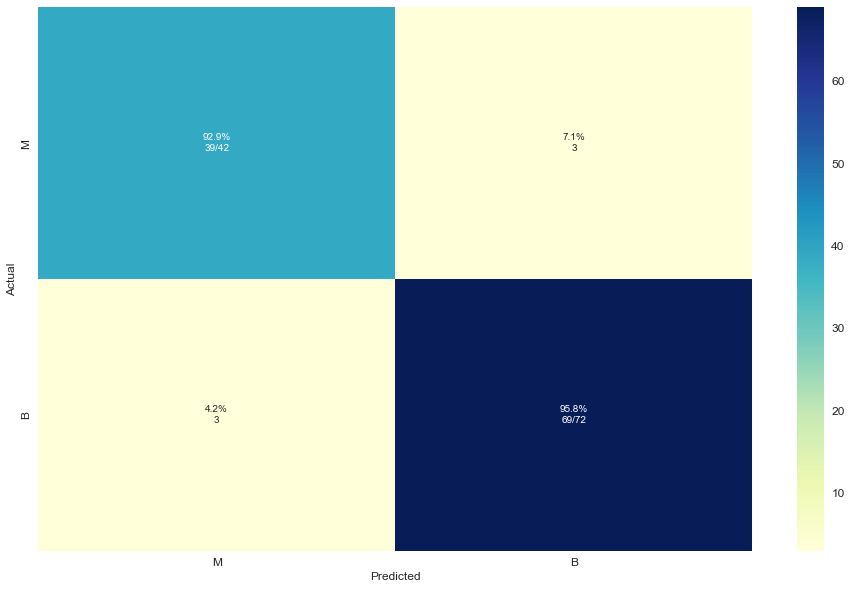

In [83]:
plot_custom_confusion_matrix(
    y_val, 
    predicted_HS, 
    'Val set (threshold moved to optimal) - XGBoost HS model', 
    ['M', 'B'], 
    ymap=None, 
    figsize=(16,10)
)

## Tabla con las features más importantes del modelo

In [86]:
sorted_idx = model_HS.feature_importances_.argsort()
importances = pd.DataFrame(
    {
        'features' : X.columns[sorted_idx], 
        'importance' : model_HS.feature_importances_[sorted_idx]}
).sort_values(
    by=['importance'], 
    ascending=True
)
importances = importances[importances['importance'] > 0.01]
importances

,features,importance
8,symmetry_worst,0.021524
9,texture_mean,0.021941
10,smoothness_worst,0.027451
11,area_se,0.041606
12,smoothness_mean,0.051380
13,area_mean,0.070376
14,concavity_worst,0.179077
15,concavity_mean,0.562003


## Gráfico de barras de la importancia de las features del modelo

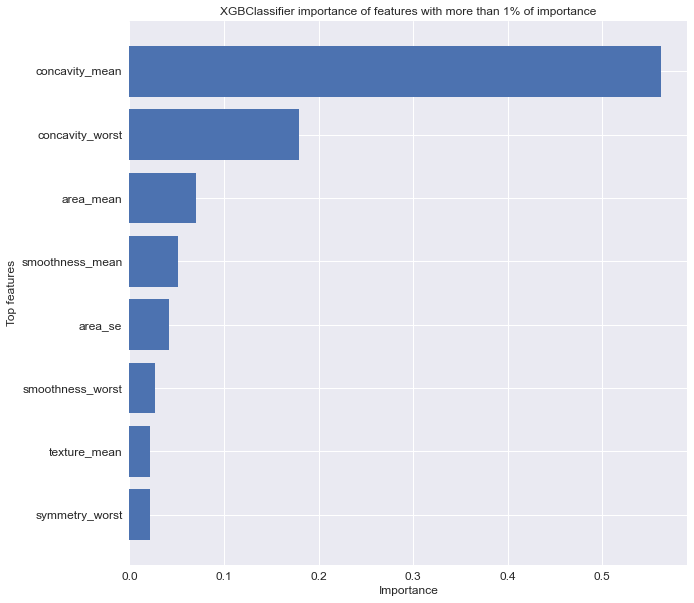

In [88]:
fig, axis = plt.subplots(figsize=(10, 10))
plt.barh(importances['features'], importances['importance'])
plt.title("XGBClassifier importance of features with more than 1% of importance")
plt.xlabel("Importance")
plt.ylabel("Top features")
_ = plt.show()